# Importing Libraries

In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

from IPython.display import Audio
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


## Testing Visualization

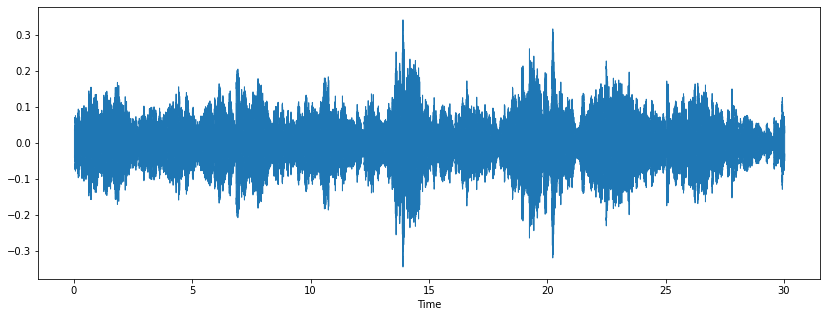

In [2]:
file_name = "./samples/classical.wav"

y, sr = librosa.load(file_name, sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

## Playing Sound

In [4]:
Audio(data=y,rate=sr)

## Preprocessing of Audio Data

Total Chunks: 15


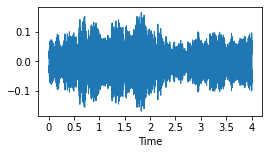

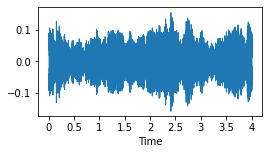

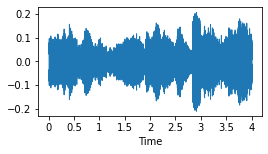

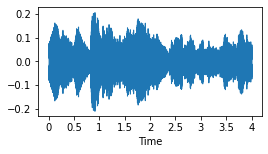

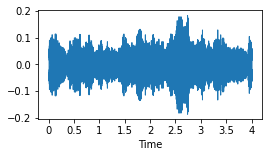

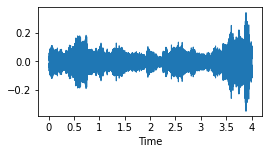

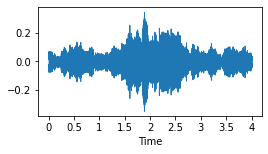

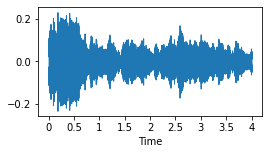

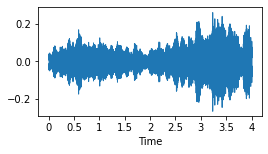

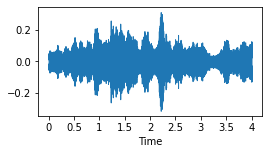

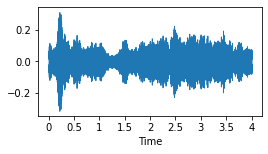

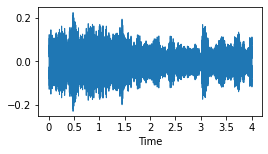

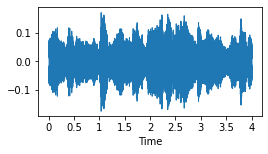

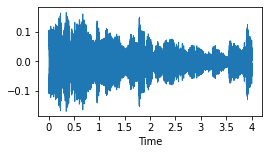

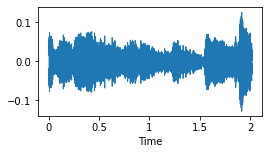

In [4]:
audio_path = "./samples/classical.wav"
y, sr = librosa.load(audio_path, sr=None)  #? sr=None to keep the original sampling rate

#! Define the duration of each chunk and overlap
chunk_duration = 4  # seconds
overlap_duration = 2  # seconds

#! Convert durations to samples
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

#! Calculate the number of chunks
num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
print("Total Chunks:", num_chunks)

#! Iterate over each chunk
for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    #? Extract the chunk of audio
    chunk = y[start:end]
    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()

In [5]:
def plot_melespectrogram_chunk(y,sr):
    #! Define the duration of each chunk and overlap
    chunk_duration = 4  # seconds
    overlap_duration = 2  # seconds

    #! Convert durations to samples
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    #! Calculate the number of chunks
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    print("Total Chunks:", num_chunks, "\n")

    #! Iterate over each chunk
    for i in range(num_chunks):
        print("Chunk:", i+1)

        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = y[start:end]        #? Extract the chunk of audio

        #? result is 2d array, each column is a time frame and each row is a mel frequency band
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)        #? Convert to decibels (log scale)

        # print(spectrogram.shape)

        plt.figure(figsize=(14,5))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()


Total Chunks: 15 

Chunk: 1


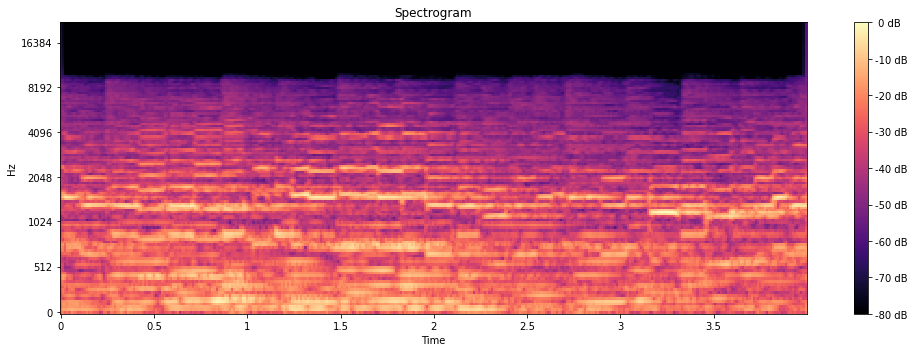

Chunk: 2


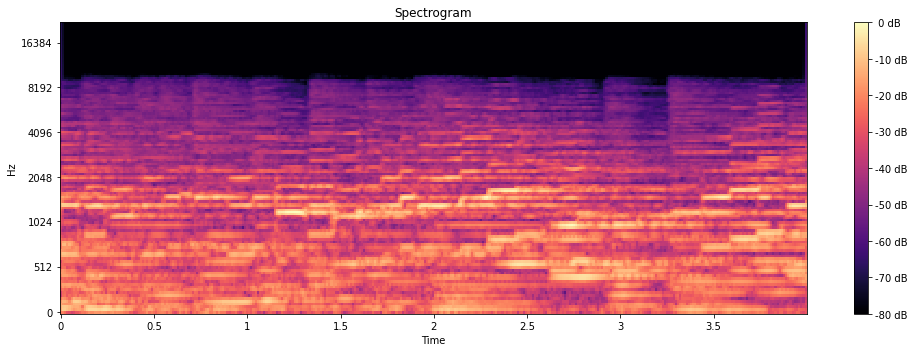

Chunk: 3


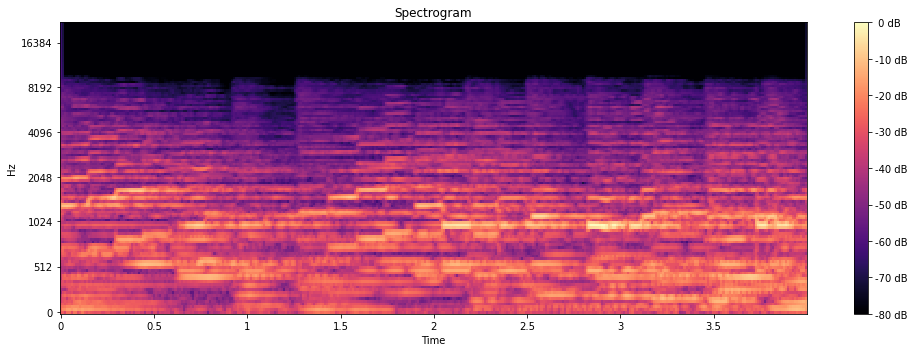

Chunk: 4


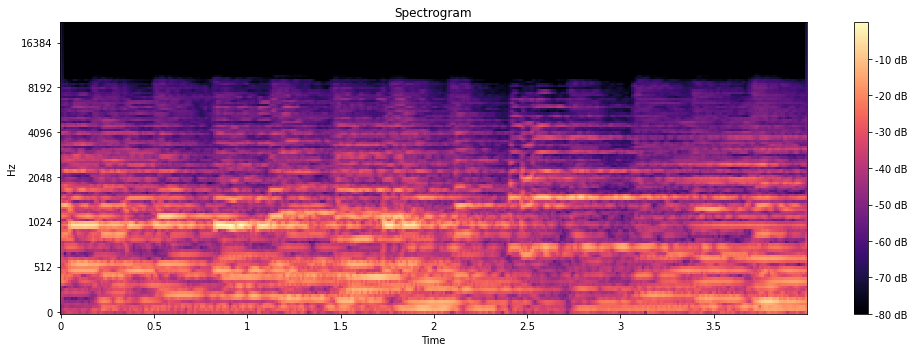

Chunk: 5


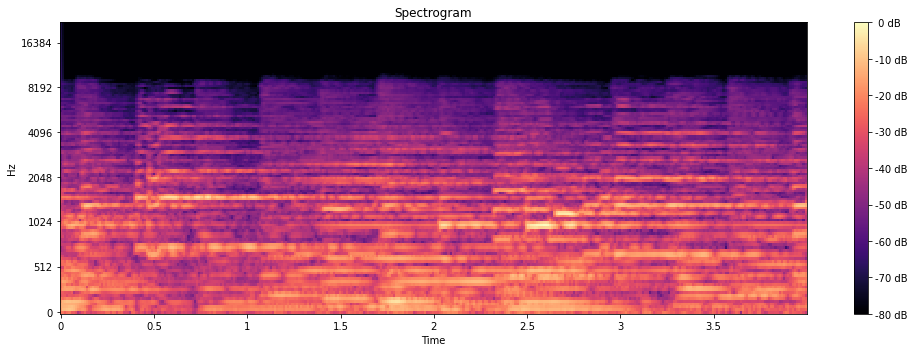

Chunk: 6


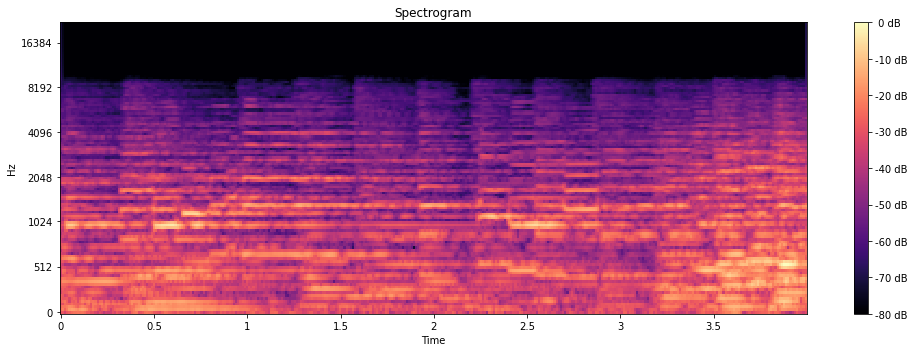

Chunk: 7


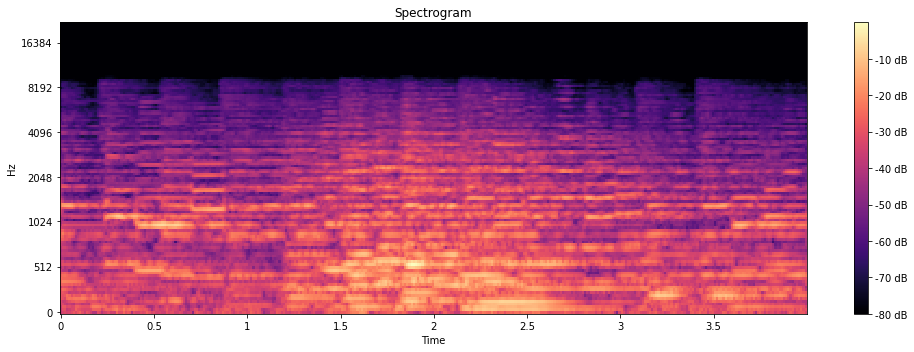

Chunk: 8


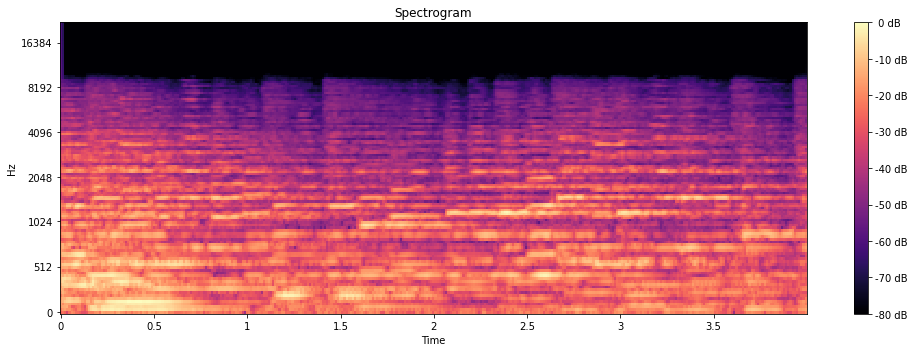

Chunk: 9


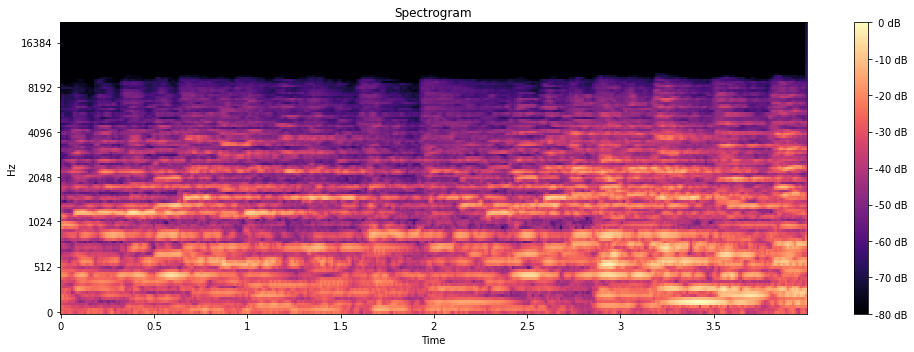

Chunk: 10


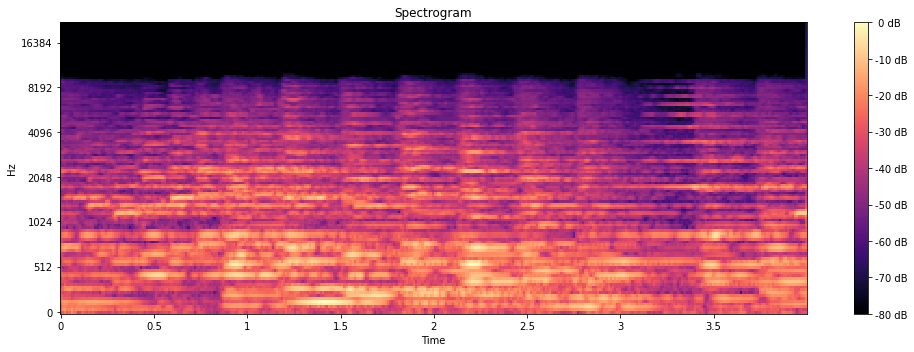

Chunk: 11


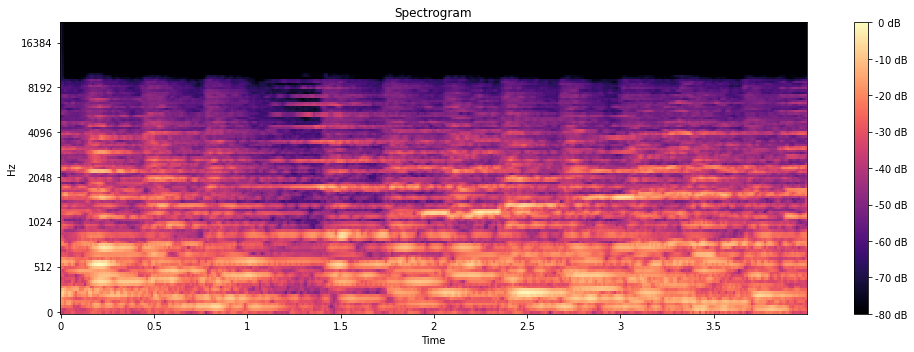

Chunk: 12


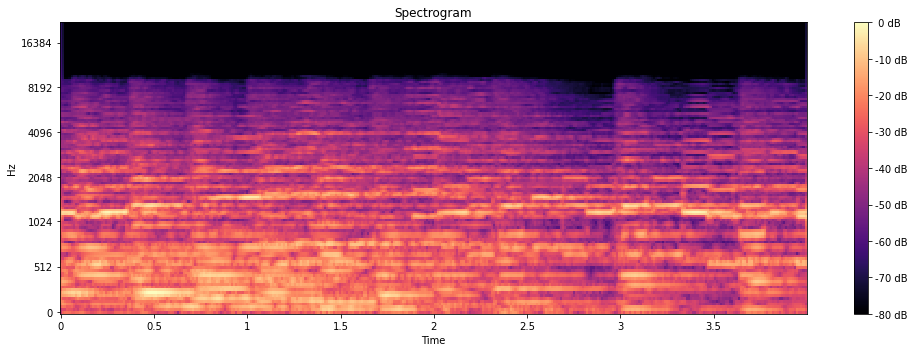

Chunk: 13


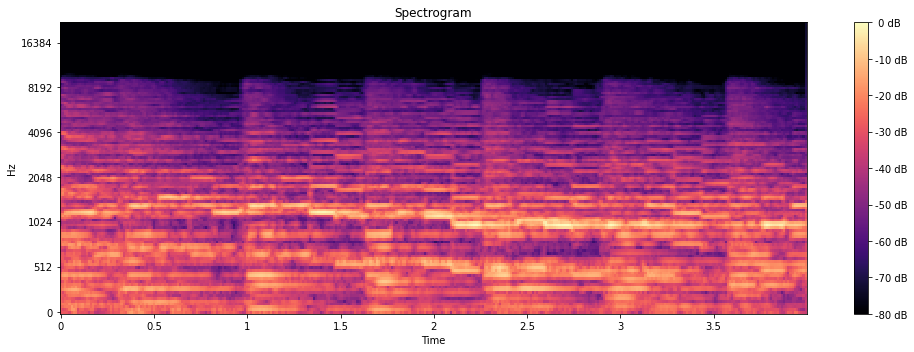

Chunk: 14


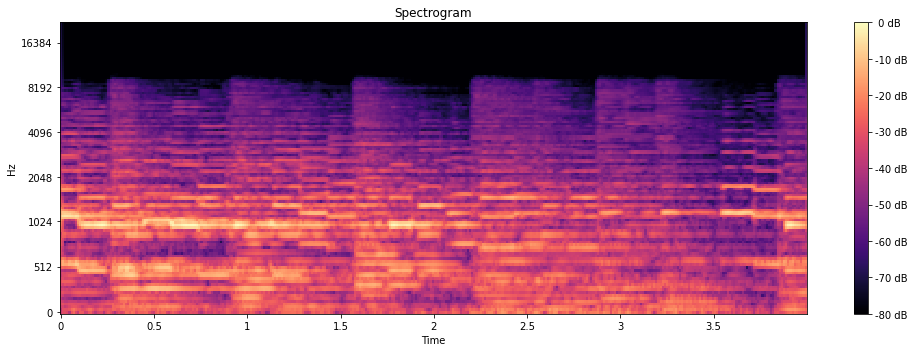

Chunk: 15


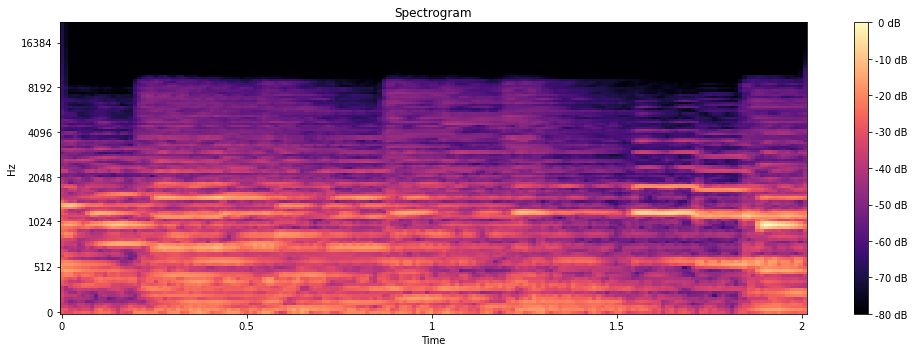

In [6]:
file_name = "./samples/classical.wav"
y,sr = librosa.load(file_name,sr=44100)
plot_melespectrogram_chunk(y,sr)

### Final Pipeline

In [7]:
data_dir = "./dataset/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [8]:
def load_and_preprocess_data(data_dir,classes,target_shape=(210,210)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)

        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                chunk_duration = 4
                overlap_duration = 2

                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                for i in range(num_chunks):
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    chunk = audio_data[start:end]

                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)

                    data.append(mel_spectrogram)
                    labels.append(i_class)

    return np.array(data),np.array(labels)

In [ ]:
data,labels = load_and_preprocess_data(data_dir,classes)

In [ ]:
print(data.shape)
print(labels.shape)
print(data)

In [12]:
labels = to_categorical(labels,num_classes = len(classes))
labels.shape

(14975, 10)

In [ ]:
np.save("data.npy", data)
np.save("labels.npy", labels)

## Data Splitting

In [10]:
data = np.load("data.npy")
labels = np.load("labels.npy")

print(data.shape)
print(labels.shape)

(14975, 210, 210, 1)
(14975,)


In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

## Model Building

In [12]:
model = tf.keras.models.Sequential()

In [56]:
X_train[0].shape

(210, 210, 1)

In [ ]:
# less effective model
# accuracy: 0.2839 - loss: 2.0664; val_accuracy: 0.2766 - val_loss: 2.0793
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape, name='Conv2D_16'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_1'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='Conv2D_32'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_2'))

model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='Conv2D_64'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_3'))

model.add(Flatten(name='Flatten'))
model.add(Dense(units=256, activation='relu', name='Dense_256'))
model.add(Dropout(0.6))

model.add(Dense(units=len(classes), activation='softmax', name='Output'))

model.summary()


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
training_history = model.fit(X_train,Y_train,epochs=25,batch_size=32,validation_data=(X_test,Y_test))

In [ ]:
train_loss,train_accuracy = model.evaluate(X_train,Y_train)
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

print(train_loss,train_accuracy)
print(val_loss,val_accuracy)

In [ ]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_history['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history['val_loss'],label="Validation Loss",color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [ ]:
# accuracy: 0.5369 - loss: 1.3565 - val_accuracy: 0.5890 - val_loss: 1.2355
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape, name='Conv2D_16'))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', name='Conv2D_16_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_1'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='Conv2D_32'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_32_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_2'))

model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='Conv2D_64'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', name='Conv2D_64_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_3'))

model.add(Flatten(name='Flatten'))
model.add(Dense(units=256, activation='relu', name='Dense_256'))
model.add(Dropout(0.5))

model.add(Dense(units=len(classes), activation='softmax', name='Output'))

model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
training_history = model.fit(X_train,Y_train,epochs=25,batch_size=32,validation_data=(X_test,Y_test))

In [ ]:
train_loss,train_accuracy = model.evaluate(X_train,Y_train)
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

print(train_loss,train_accuracy)
print(val_loss,val_accuracy)

In [ ]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_history['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history['val_loss'],label="Validation Loss",color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [ ]:
# accuracy: 0.6378 - loss: 1.0352 - val_accuracy: 0.6928 - val_loss: 0.9153
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape, name='Conv2D_32'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_32_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_1'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='Conv2D_64'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', name='Conv2D_64_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_2'))

model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2D_128'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', name='Conv2D_128_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_3'))

model.add(Flatten(name='Flatten'))
model.add(Dense(units=256, activation='relu', name='Dense_256'))
model.add(Dropout(0.5))

model.add(Dense(units=len(classes), activation='softmax', name='Output'))

model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
training_history = model.fit(X_train,Y_train,epochs=25,batch_size=32,validation_data=(X_test,Y_test))

In [ ]:
train_loss,train_accuracy = model.evaluate(X_train,Y_train)
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

print(train_loss,train_accuracy)
print(val_loss,val_accuracy)

In [ ]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_history['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history['val_loss'],label="Validation Loss",color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [ ]:
# accuracy: 0.9888 - loss: 0.0352 - val_accuracy: 0.9255 - val_loss: 0.2932
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape, name='Conv2D_32'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_32_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_1'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='Conv2D_64'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', name='Conv2D_64_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_2'))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2D_128'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', name='Conv2D_128_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_3'))

model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='Conv2D_256'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', name='Conv2D_256_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_4'))

model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='Conv2D_512'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu', name='Conv2D_512_2'))
model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPool2D_5'))

model.add(Dropout(0.5))
model.add(Flatten(name='Flatten'))

model.add(Dense(units=800, activation='relu', name='Dense_1200'))
model.add(Dropout(0.5))
model.add(Dense(units=len(classes), activation='softmax', name='Output'))

model.summary()

c:\Users\Mayank\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_32 (Conv2D)              │ (None, 210, 210, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_32_2 (Conv2D)            │ (None, 208, 208, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_1 (MaxPooling2D)      │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_64 (Conv2D)              │ (None, 104, 104, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_64_2 (Conv2D)            │ (None, 102, 102, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_2 (MaxPooling2D)      │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_128 (Conv2D)             │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_128_2 (Conv2D)           │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_3 (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_256 (Conv2D)             │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_256_2 (Conv2D)           │ (None, 22, 22, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_4 (MaxPooling2D)      │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_512 (Conv2D)             │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_512_2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_5 (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1200 (Dense)              │ (None, 1200)           │     9,831,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,555,258 (55.52 MB)

 Trainable params: 14,555,258 (55.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
training_history = model.fit(X_train,Y_train,epochs=25,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.2223 - loss: 2.0819 - val_accuracy: 0.4694 - val_loss: 1.4968
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 787s 2s/step - accuracy: 0.5019 - loss: 1.4086 - val_accuracy: 0.6284 - val_loss: 1.1037
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.6237 - loss: 1.0861 - val_accuracy: 0.6985 - val_loss: 0.8863
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 952s 3s/step - accuracy: 0.7067 - loss: 0.8749 - val_accuracy: 0.7299 - val_loss: 0.7969
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - accuracy: 0.7589 - loss: 0.7188 - val_accuracy: 0.7786 - val_loss: 0.6535
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1407s 4s/step - accuracy: 0.7971 - loss: 0.5840 - val_accuracy: 0.8200 - val_loss: 0.5381
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1505s 4s/step - accuracy: 0.8350 - loss: 0.4770 - val_accuracy: 0.8404 - val_loss: 0.4870
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1524s 4s/step - accuracy: 0.8728 - loss: 0.3829 - val_a

In [ ]:
model.save("Trained_model.h5")

In [ ]:
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [11]:
model = tf.keras.models.load_model("Trained_model.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_32 (Conv2D)              │ (None, 210, 210, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_32_2 (Conv2D)            │ (None, 208, 208, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_1 (MaxPooling2D)      │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_64 (Conv2D)              │ (None, 104, 104, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_64_2 (Conv2D)            │ (None, 102, 102, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_2 (MaxPooling2D)      │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_128 (Conv2D)             │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_128_2 (Conv2D)           │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_3 (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_256 (Conv2D)             │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_256_2 (Conv2D)           │ (None, 22, 22, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_4 (MaxPooling2D)      │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_512 (Conv2D)             │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_512_2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_5 (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1200 (Dense)              │ (None, 1200)           │     9,831,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,555,260 (55.52 MB)

 Trainable params: 14,555,258 (55.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [12]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [13]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Model Evaluation - I

In [14]:
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 689ms/step - accuracy: 0.9897 - loss: 0.0310


In [15]:
train_loss,train_accuracy

(0.027497349306941032, 0.9911519289016724)

In [16]:
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.9223 - loss: 0.3074


In [17]:
val_loss,val_accuracy

(0.29319584369659424, 0.9255425930023193)

## Accuracy and Loss Visualization

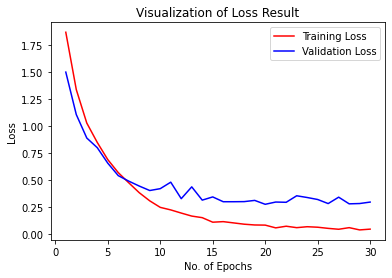

In [18]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

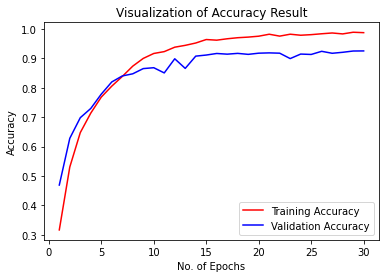

In [19]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()